# Make RPKM Tables from RNA-Seq data (HT-Seq counts ) 

In [1]:
%matplotlib inline
import collections
import pandas as pd
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import stats
import seaborn as sns

### Read in reference genome, grab gene name from GTF

In [2]:
genes_df=pd.read_table("U00096.3.gtf",header=None)
genes_df["Gene name"]=genes_df[8].apply(lambda x: x.split(';')[4].split('=')[1])
genes_df=genes_df.loc[:,[6,'Gene name']]

### Split counts into TS and NTS based on orientation of the gene

In [3]:
def gen_df(sample_lis,strand):
    df_lis=[]
    for sample in sample_lis:
        plus_df=pd.read_table('2020_htseq_results/'+sample+"_fwd_genes.txt",header=None)
        plus_df=plus_df.iloc[0:4419,:]
        plus_df.columns=['Gene name','plus_count']
        plus_df=plus_df.merge(genes_df, on ='Gene name')
        minus_df=pd.read_table('2020_htseq_results/'+sample+"_rev_genes.txt",header=None)
        minus_df=minus_df.iloc[0:4419,:]
        minus_df.columns=['Gene name','minus_count']
        minus_df=minus_df.merge(genes_df, on ='Gene name')
        merge_df=pd.merge(plus_df,minus_df)
        plusgenes_df=merge_df[merge_df[6]=='+']
        plusgenes_df.columns=['Gene name',sample+'_TS',6,sample+'_NTS']
        minusgenes_df=merge_df[merge_df[6]=='-']
        minusgenes_df.columns=['Gene name',sample+'_NTS',6,sample+'_TS']
        joined_df=pd.concat([plusgenes_df,minusgenes_df])
        joined_df=joined_df.loc[:,['Gene name',sample+"_"+strand]]
        joined_df=joined_df.sort_index()
        df_lis.append(joined_df)
    df_final = reduce(lambda left,right: pd.merge(left,right,on='Gene name'), df_lis)
    return df_final

### Create table with HT-Seq counts for both TS and NTS

In [4]:
final_df_NTS=gen_df(['bm01','bm05','bm08','bm03','bm12','bm10','bm02','bm06','bm09','bm04','bm07','bm11'],'NTS')
final_df_TS=gen_df(['bm01','bm05','bm08','bm03','bm12','bm10','bm02','bm06','bm09','bm04','bm07','bm11'],'TS')

/home/britney/.local/share/virtualenvs/2018-05-22_RNAseq-cwNEjjgQ/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### Import gene lengths for RPKM calculation

In [5]:
gene_lengths=pd.read_csv('gene_lengths',index_col=0)
gene_lengths['length']=gene_lengths['length']/1000

### Function norm_df uses count tables to calculate RPKM for each sample

In [6]:
def norm_df(df,s):
    df=df.merge(gene_lengths)
    df=df.iloc[:,0:][(df.iloc[:,1:13] > 0).all(1)]
    value_dict={'bm01':33242960,'bm05':30709888,'bm08':42227326,'bm03':28285744,'bm12':26316536,'bm10':31653676,'bm02':26490734,'bm06':23513234,'bm09':38220972,'bm04':34486716,'bm07':28927064,'bm11':31092886}

    for value in value_dict:
        df[value+'_'+s]=(df[value+'_'+s]/(value_dict[value]/1000000))
    df=df.set_index('Gene name')
    df=df.iloc[:,0:12].div(df.length, axis=0)
    
    return df

In [7]:
TS_rpkm=norm_df(final_df_TS,'TS')
NTS_rpkm=norm_df(final_df_NTS,'NTS')

### Function t performs ttest and pvalue_calc calculates the pvalue and log2-fold change of each gene between two different samples

In [8]:
def t(x1,x2):
    x=stats.ttest_ind(x1,x2)
    return x.pvalue

In [9]:
def pvalue_calc(df,sample1,sample_lis1,sample2,sample_lis2):
    mean_df=pd.DataFrame()
    mean_df[sample1+' mean']=df.loc[:,sample_lis1].mean(axis=1)
    mean_df[sample1]=df.loc[:,sample_lis1].loc[:, :].values.tolist()
    mean_df[sample2+' mean']=df.loc[:,sample_lis2].mean(axis=1)
    mean_df[sample2]=df.loc[:,sample_lis2].loc[:, :].values.tolist()
    mean_df[sample1+sample2+'_pvalue']=mean_df.apply(lambda x: t(x[sample1],x[sample2]),axis=1)
    mean_df['log2fold']=np.log2(mean_df[sample2+' mean']/mean_df[sample1+' mean'])
    
    return mean_df

In [55]:
mfd=pvalue_calc(NTS_rpkm,'mfd -uv',['bm02_NTS','bm06_NTS','bm09_NTS'],'mfd +uv',['bm04_NTS','bm07_NTS','bm11_NTS'])


In [56]:
wt=pvalue_calc(NTS_rpkm,'wt -uv',['bm01_NTS','bm05_NTS','bm08_NTS'],'wt +uv',['bm03_NTS','bm12_NTS','bm10_NTS'])



In [67]:
uvminus=pvalue_calc(NTS_rpkm,'wt -uv',['bm01_NTS','bm05_NTS','bm08_NTS'],'mfd -uv',['bm02_NTS','bm06_NTS','bm09_NTS'])

In [57]:
p_filtered_mfd =mfd[mfd['mfd -uvmfd +uv_pvalue']<=0.05]
p_filtered_wt =wt[wt['wt -uvwt +uv_pvalue']<=0.05]

### Scatter plot of RPKM between two different samples (from df created by pvalue_calc function and/or a filtered version of that dataframe

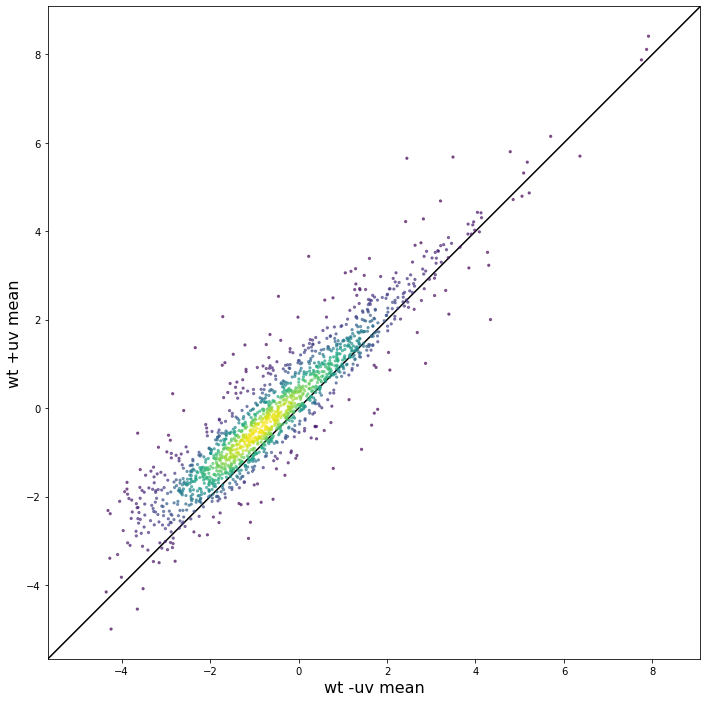

In [89]:

first='wt -uv mean'
second='wt +uv mean'
first_lis=np.log2(mfd_wt[first].tolist())
second_lis=np.log2(mfd_wt[second].tolist())
#third_lis=np.log2(p_filtered[first].tolist())
#fourth_lis=np.log2(p_filtered[second].tolist())
x=first_lis
y=second_lis
#z=third_lis
#w=fourth_lis
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(x,y,s=5,c=z,alpha=0.6)
#ax.scatter(z,w,s=5,c='#D71C1C',alpha=1)
ax.set_xlabel(first,fontsize='16')
ax.set_ylabel(second,fontsize='16')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
ax.plot(lims, lims, 'k-', alpha=1, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

    #fig.savefig(sample2+strand+"correlation_allgenes.pdf",transparent=True)
plt.show() 

### Volcanoe plot (from df created by pvalue_calc and/or the p_filtered version of the dataframe)

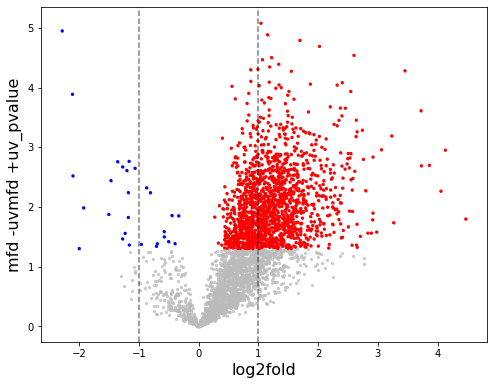

In [13]:

first='log2fold'
second='mfd -uvmfd +uv_pvalue'
first_lis=test[first].tolist()
second_lis=-np.log10(test[second].tolist())
third_lis=p_filtered[first].tolist()
fourth_lis=-np.log10(p_filtered[second].tolist())
x=first_lis
y=second_lis
z=third_lis
w=fourth_lis

fig, ax = plt.subplots(figsize=(8, 8))
c = [ 'r' if i > 0 else 'b' for i in z]
ax.scatter(x,y,s=5,c='#BBBBBB',alpha=0.7)
ax.scatter(z,w,s=5,c=c,alpha=1)
ax.set_xlabel(first,fontsize='16')
ax.set_ylabel(second,fontsize='16')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
#ax.plot(0, 1, 'k-', alpha=1)
plt.axvline(x=1,c='black',linestyle='--',alpha=0.5)
plt.axvline(x=-1,c='black',linestyle='--',alpha=0.5)
ax.set_aspect('equal')
#ax.set_xlim([-5,6])
#ax.set_ylim([-5,6])

    #fig.savefig(sample2+strand+"correlation_allgenes.pdf",transparent=True)
plt.show() 

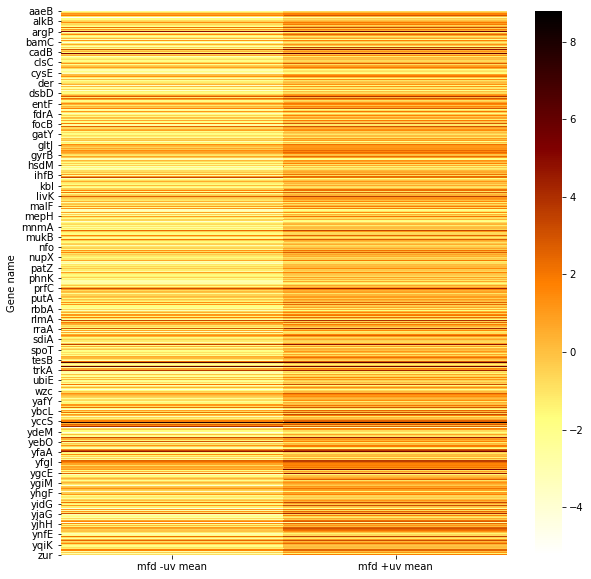

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log2(subset),cmap="afmhot_r",ax=ax)

In [61]:
subset=p_filtered_wt.loc[:,['wt -uv mean','wt +uv mean']]

Text(86.0, 0.5, '')

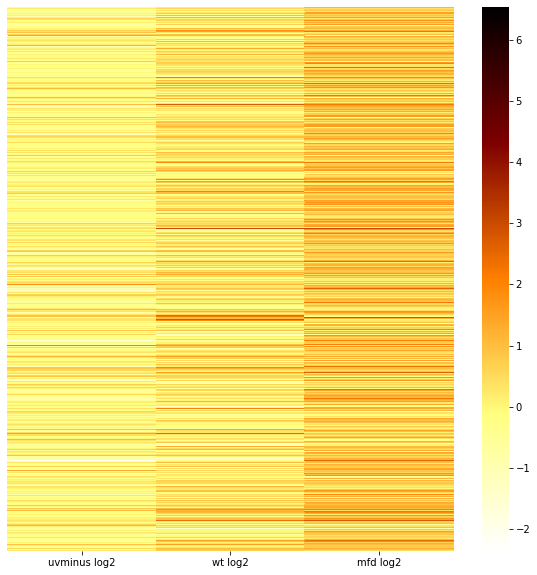

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(log2_df,cmap="afmhot_r",ax=ax,yticklabels=False)
ax.set_ylabel('')    


In [70]:
log2_df=pd.DataFrame()
log2_df['uvminus log2']=uvminus['log2fold']
log2_df['wt log2']=wt['log2fold']
log2_df['mfd log2']=mfd['log2fold']


In [90]:
mfd_wt_uvminus

,mfd -uv mean,mfd -uv,mfd +uv mean,mfd +uv,mfd -uvmfd +uv_pvalue,log2foldmfd,log2foldwt,log2fold
Gene name,,,,,,,,
aaeB,0.507818,"[0.5373530021795492, 0.45404883835332444, 0.53...",1.043209,"[0.8402696069531234, 1.1775140189086177, 1.111...",0.007392,1.038645,0.159215,-0.291306
aas,0.438258,"[0.3496901195286089, 0.492464580736777, 0.4726...",0.971864,"[0.8998504118276427, 1.136845245786267, 0.8788...",0.004751,1.148976,0.209775,-0.317295
aat,0.248884,"[0.2681040369539299, 0.1812325618995514, 0.297...",0.626891,"[0.4942614583961704, 0.883884441856312, 0.5025...",0.046930,1.332743,0.148312,-0.273397
abgT,0.524381,"[0.544219570687086, 0.6688740423448711, 0.3600...",0.820346,"[0.8930823031570821, 0.724921679996323, 0.8430...",0.044831,0.645616,0.028941,-0.434146
abpA,1.009281,"[1.074539744148028, 1.0790215896593751, 0.8742...",2.404145,"[2.404427028633515, 2.738194266520764, 2.06981...",0.002412,1.252196,0.651744,-0.108324
...,...,...,...,...,...,...,...,...
znuC,0.225635,"[0.29999243764063577, 0.1689903623540188, 0.20...",0.942506,"[0.7297175791950525, 1.373630567476476, 0.7241...",0.030708,2.062510,0.526376,-0.324130
zraP,0.783496,"[0.8882129036026666, 0.6004128168342785, 0.861...",1.667668,"[1.7056866015240393, 1.7081500115560415, 1.589...",0.000900,1.089835,0.903337,0.203163
zraS,0.136710,"[0.10808603694520638, 0.15221632495500378, 0.1...",0.373135,"[0.3321021872688179, 0.39593073860930167, 0.39...",0.000704,1.448581,2.200726,1.006744


In [87]:
mfd_wt=p_filtered_mfd.join(wt.loc[:,['log2fold']],lsuffix='mfd',rsuffix='wt')

In [80]:
mfd_wt_uvminus=mfd_wt.join(uvminus.loc[:,['log2fold']],rsuffix='uvminus')

In [85]:
sub=mfd_wt_uvminus.loc[:,['log2fold','log2foldwt','log2foldmfd']]

Text(86.0, 0.5, '')

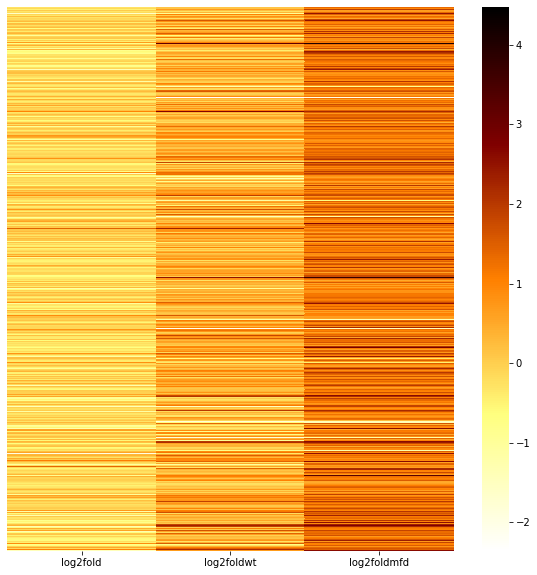

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(sub,cmap="afmhot_r",ax=ax,yticklabels=False)
ax.set_ylabel('')

In [12]:
downstream_rho=pd.read_csv('opp_downstream_rho.csv',index_col=1)

In [215]:
filtered=downstream_rho.join(test)

In [94]:
filtered=filtered.dropna()

In [45]:
rho_lis=filtered.index.to_list()

In [60]:
def rho_down(row):
    
    if row[6] in rho_lis:
        return 1
    else:
        return 0

In [62]:
mean_df['downstream_rho']=mean_df.apply(lambda row:rho_down(row),axis=1)

In [55]:
mean_df['Gene']=mean_df.index

In [156]:
filtered=mean_df[mean_df['wt-uvmfd+uv_pvalue']<0.059]

In [85]:
filtered=mean_df.sort_values(by='downstream_rho')